In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


We know that training data was recorded during years of Covid-19 pandemic, which significantly increased emissions all oer the world. That means that trends, recorded during this period, are much different from trends, recorded later. We can try detrending so that predictions won't be affected by previous data.

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.tsa.tsatools import detrend
from lightgbm import LGBMRegressor as lgbm_r

#### Dataset import

In [3]:
#dataset import
train_data = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv', index_col=['ID_LAT_LON_YEAR_WEEK'])
test_data = pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv', index_col=['ID_LAT_LON_YEAR_WEEK'])

In [4]:
train_data.head(10)

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,,,,,,
ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317
ID_-0.510_29.290_2019_05,-0.51,29.29,2019,5,0.000294,0.871713,0.000242,0.227656,-13.453690,57.097124,...,5530.354546,49846.001010,4495.301362,7.556143,0.250228,30.128401,37.007020,-137.388719,21.157820,4.310819
ID_-0.510_29.290_2019_06,-0.51,29.29,2019,6,-0.000285,0.791956,-0.000226,0.119397,72.198647,58.496368,...,4378.614648,58804.276563,3537.050659,10.493107,0.240828,4.585368,30.491541,-128.196338,21.721202,4.269334
ID_-0.510_29.290_2019_07,-0.51,29.29,2019,7,-0.000016,0.976311,-0.000016,0.106799,-100.956055,23.739841,...,3468.924146,63697.007267,2597.071563,20.533600,0.250168,16.374829,35.840248,-122.250699,20.432005,4.251361
ID_-0.510_29.290_2019_08,-0.51,29.29,2019,8,-0.000115,0.796941,-0.000101,0.164971,-40.179074,31.161560,...,3160.264670,67222.556159,2530.851476,24.253928,0.260543,-12.021751,42.688789,-114.296369,22.365602,4.281937


In [5]:
train_data.describe()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023.000000,79023.000000,79023.000000,79023.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,...,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,79023.000000
mean,-1.891072,29.880155,2020.000000,26.000000,0.000048,0.834848,0.000035,0.158418,-7.925870,37.436189,...,5592.377478,59420.297456,4670.430869,19.139241,0.271460,-10.784832,40.436976,-86.800583,27.925981,81.940552
std,0.694522,0.810375,0.816502,15.297155,0.000272,0.185382,0.000206,0.071364,64.263368,14.149950,...,1428.503002,9051.163609,1359.251583,13.547047,0.049434,30.374462,6.428216,37.837269,4.403835,144.299648
min,-3.299000,28.228000,2019.000000,0.000000,-0.000996,0.241822,-0.000887,0.000000,-179.537059,0.099237,...,1050.661782,24779.033704,1050.496816,1.844529,0.017697,-102.739731,2.998873,-153.464211,10.818288,0.000000
25%,-2.451000,29.262000,2019.000000,13.000000,-0.000096,0.705817,-0.000078,0.110535,-56.782383,28.844520,...,4595.400519,53175.779928,3680.856344,9.974574,0.241453,-30.309170,35.829907,-125.991158,24.686763,9.797995
50%,-1.882000,29.883000,2020.000000,26.000000,0.000024,0.809118,0.000019,0.161855,-12.441726,37.784299,...,5573.854309,59332.532548,4621.755170,15.130688,0.272747,-12.673914,41.119630,-84.644352,28.333630,45.593445
75%,-1.303000,30.471000,2021.000000,39.000000,0.000153,0.942792,0.000121,0.211824,72.059990,47.634875,...,6542.303642,65663.842684,5572.983223,23.785030,0.302892,9.402202,44.446272,-48.132701,31.499883,109.549595
max,-0.510000,31.532000,2021.000000,52.000000,0.004191,1.885239,0.004236,0.299998,122.095200,66.242012,...,12384.239458,89291.615576,11384.239458,250.000000,0.736514,78.223037,65.951248,-22.653170,42.060436,3167.768000


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   latitude                                                  79023 non-null  float64
 1   longitude                                                 79023 non-null  float64
 2   year                                                      79023 non-null  int64  
 3   week_no                                                   79023 non-null  int64  
 4   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 5   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 6   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 7   SulphurDioxide_cloud_fraction                             64414 no

Emissions per measurement boxplot

Text(0, 0.5, 'Emission Amount')

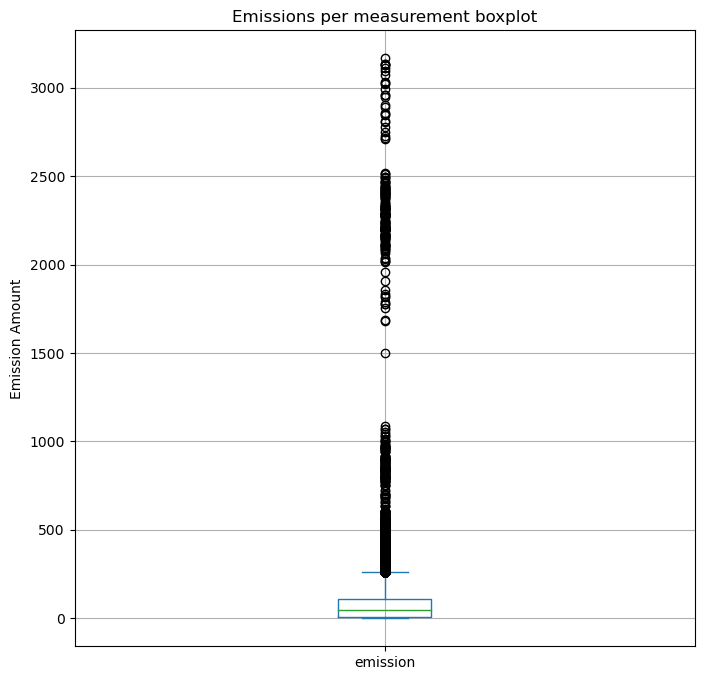

In [7]:
train_data.emission.plot(kind='box', figsize=(8, 8), title = 'Emissions per measurement boxplot', grid=True)
plt.ylabel('Emission Amount')

Percentage of measurements when amount of emissions was above 1500:

In [8]:
'{:.1%}'.format(train_data.emission[train_data.emission >= 1500].sum() / train_data.emission[train_data.emission < 1500].sum())

'7.2%'

## Creating time series

In [9]:
#Let's cut the data and keep only coordinates, time info and target emission value.
cleared_train_data = train_data.loc[:,['latitude','longitude','year','week_no','emission']]


In [10]:
def get_time_series(cleared_data):
    cleared_data['date'] = pd.to_datetime(cleared_data.year.astype(str) + '-' + cleared_data.week_no.astype(str) + '0', format='%Y-%W%w')
    cleared_data = cleared_data.set_index(pd.DatetimeIndex(cleared_data['date']))
    return cleared_data.drop(['date'], axis=1)

In [11]:
cleared_train_data = get_time_series(cleared_train_data)

In [12]:
cleared_train_data.loc['2019-01-06']

,latitude,longitude,year,week_no,emission
date,,,,,
2019-01-06,-0.510,29.290,2019,0,3.750994
2019-01-06,-0.528,29.472,2019,0,3.857115
2019-01-06,-0.547,29.653,2019,0,0.500023
2019-01-06,-0.569,30.031,2019,0,100.382980
2019-01-06,-0.598,29.102,2019,0,0.076542
...,...,...,...,...,...
2019-01-06,-3.153,30.347,2019,0,15.069341
2019-01-06,-3.161,28.839,2019,0,0.106631
2019-01-06,-3.174,29.926,2019,0,41.193130


## Seasonal decomposition using STL

In [13]:
from statsmodels.tsa.seasonal import STL

In [14]:
stl_decomposition = STL(cleared_train_data.emission, period=52).fit()

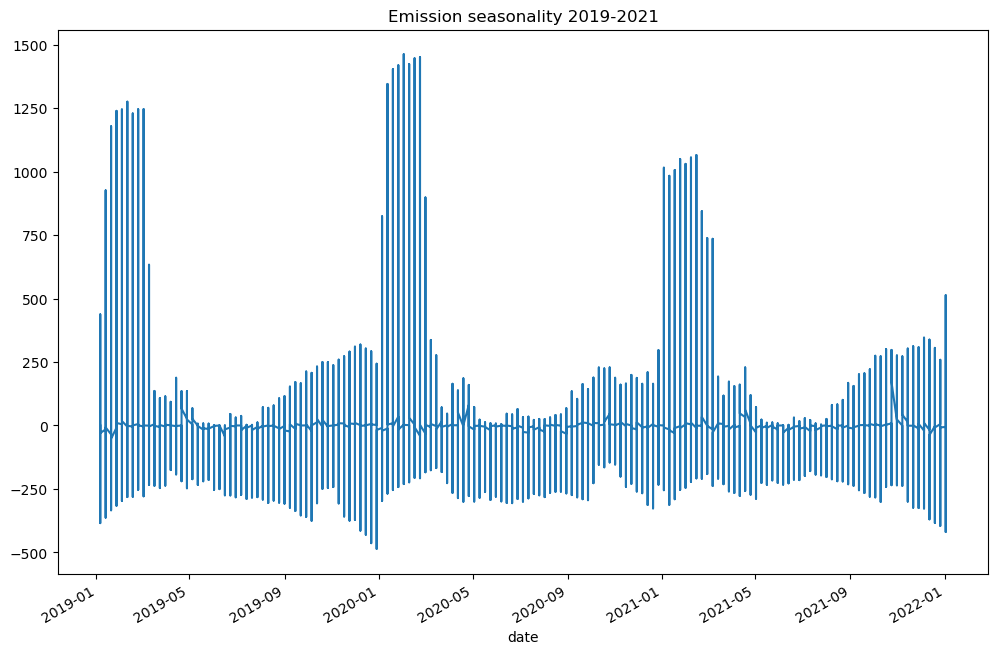

In [15]:
fig = plt.figure(figsize=(12,8))
stl_decomposition.seasonal.plot()
plt.title('Emission seasonality 2019-2021')
plt.show()

The plot shows that seasonality was yearly and the spikes were occuring between January and May.

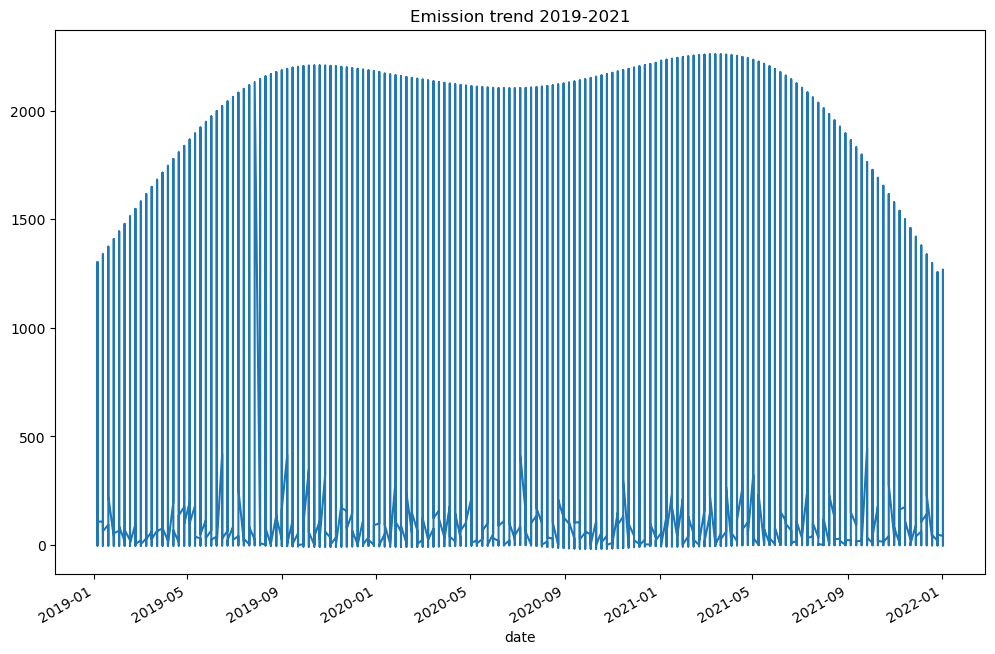

In [16]:
fig = plt.figure(figsize=(12,8))
stl_decomposition.trend.plot()
plt.title('Emission trend 2019-2021')
plt.show()

The plot shows that at the start of the year trend was ascending, but to the end of the year it became descending. We can work around that and try to detrend time series so it wouldn't affect our data.

## Prediction without detrending

Let's train LinearRegression and measure RMSE for predictions. We will split training data into train and valid with valid size = 0.2

In [17]:
train_features, valid_features, train_target, valid_target = train_test_split(cleared_train_data.drop('emission', axis=1), cleared_train_data.emission, shuffle=False, test_size=0.2)

In [18]:
fit = LinearRegression().fit(train_features, train_target)

In [19]:
prediction = fit.predict(valid_features)

In [20]:
mean_squared_error(valid_target, prediction, squared=False)

96.1109026403492

Prediction with detrending

In [21]:
train_target_d = detrend(train_target, order=2)

In [22]:
fit_d = LinearRegression().fit(train_features, train_target_d)

In [23]:
prediction_d = fit_d.predict(valid_features)

In [24]:
mean_squared_error(valid_target, prediction_d, squared=False)

65.31272688596043

Metric improved by 67% from 96.11 to 65.31

## Submission

In [25]:
cleared_test_data = test_data.loc[:,['latitude','longitude','year','week_no']]

In [26]:
model = LinearRegression()
train_features_submission = cleared_train_data.drop('emission', axis=1)
train_target_submission = detrend(cleared_train_data.emission)
model.fit(train_features_submission, train_target_submission)
predicted = model.predict(cleared_test_data)
predicted

array([-23.63136447, -23.56442922, -23.49749397, ...,  10.86076742,
        10.92770268,  10.99463793])

In [27]:
test_ids = cleared_test_data.index
test_ids

Index(['ID_-0.510_29.290_2022_00', 'ID_-0.510_29.290_2022_01',
       'ID_-0.510_29.290_2022_02', 'ID_-0.510_29.290_2022_03',
       'ID_-0.510_29.290_2022_04', 'ID_-0.510_29.290_2022_05',
       'ID_-0.510_29.290_2022_06', 'ID_-0.510_29.290_2022_07',
       'ID_-0.510_29.290_2022_08', 'ID_-0.510_29.290_2022_09',
       ...
       'ID_-3.299_30.301_2022_39', 'ID_-3.299_30.301_2022_40',
       'ID_-3.299_30.301_2022_41', 'ID_-3.299_30.301_2022_42',
       'ID_-3.299_30.301_2022_43', 'ID_-3.299_30.301_2022_44',
       'ID_-3.299_30.301_2022_45', 'ID_-3.299_30.301_2022_46',
       'ID_-3.299_30.301_2022_47', 'ID_-3.299_30.301_2022_48'],
      dtype='object', name='ID_LAT_LON_YEAR_WEEK', length=24353)

In [28]:
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predicted]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='ID_LAT_LON_YEAR_WEEK,emission',
    comments='',
)